In [1]:
import sys
import yaml
import numpy as np
from pathlib import Path
import hydra
from hydra import compose, initialize_config_dir
from omegaconf import DictConfig
import os

sys.path.append('../')

In [2]:
from omegaconf import OmegaConf


config_dir = os.path.abspath('../conf')
with initialize_config_dir(config_dir=config_dir, version_base=None):
    cfg = compose(config_name="config", overrides=["data=legacy"])

cfg

{'data': {'type': 'legacy', 'policy': 'random-discrete', 'out_dir': 'data/', 'signal_dim': 2, 'noise_dim': 100, 'state_dim': '???', 'traj_len': 2, 'num_actions': '???', 'static_noise': False, 'seed': 0, 'step_size': 0.3, 'n_train': 10000, 'n_val': 1000, 'n_test': 1000}, 'model': {'vae': {'z_dim': 2, 'enc_widths': [256, 256], 'dec_widths': [256, 256], 'activation': 'relu'}, 'contrastive': {'z_dim': 2, 'enc_widths': [256, 256], 'proj_widths': [256, 256], 'activation': 'relu', 'use_layer_norm': True, 'eps': 1e-05}, 'dynamics': {'dyn_widths': [256, 256], 'activation': 'relu'}, 'probe': {'probe_widths': [64, 64], 'activation': 'relu'}, 'repr': '${oc.select:model.${method}}'}, 'train': {'epochs_phase1': 100, 'epochs_phase2': 100, 'epochs_probe': 100, 'num_workers': 0, 'ckpt_dir': 'ckpts/', 'eval_batch_size': 512, 'device': 'mps', 'vae': {'lr': 0.002, 'batch_size': 256, 'weight_decay': 0.0, 'beta': 0.001, 'gradient_clip': {'enabled': False, 'max_norm': 10.0, 'norm_type': 2.0}}, 'contrastive':

In [3]:
from scripts.generate_data import main as gen_main
from utils import check_config

check_config(cfg)
gen_main(cfg)

train shapes: (20000, 102) (20000,) (20000, 102)
state mean/std: 0.0006756378 0.99956125
signal mean/std: -0.0036328575 1.0022238
actions min/max/unique: 0.0 3.0 (array([0., 1., 2., 3.], dtype=float32), array([5000, 4941, 5013, 5046]))


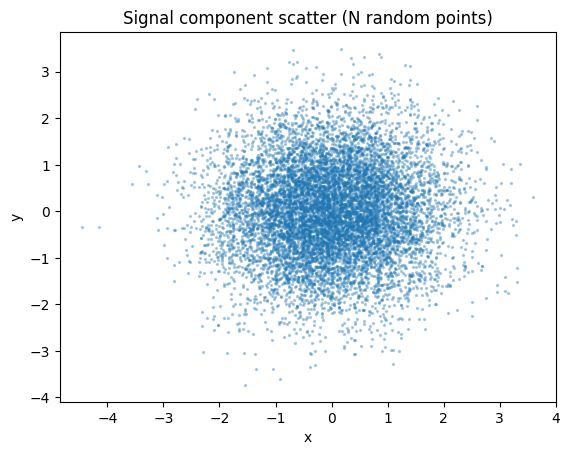

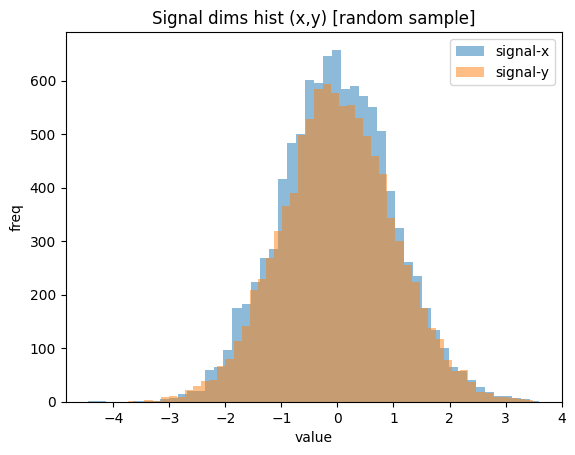

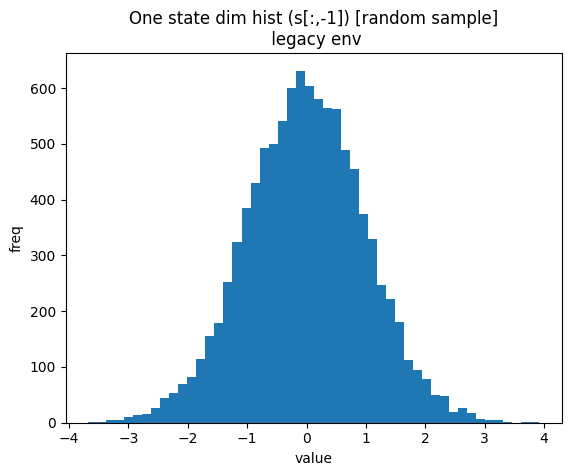

In [4]:
import matplotlib.pyplot as plt

data_dir = Path(cfg['data']['out_dir'])
train = np.load(data_dir / 'train.npz')
val = np.load(data_dir / 'val.npz')
test = np.load(data_dir / 'test.npz')

s, a, sp, sig, next_sig = train['s'], train['a'], train['sp'], train['sig'], train['sig_next']
print("train shapes:", s.shape, a.shape, sp.shape)

print("state mean/std:", s.mean(), s.std())
print("signal mean/std:", sig.mean(), sig.std())
print("actions min/max/unique:", a.min(), a.max(), np.unique(a, return_counts=True))

N = min(10000, s.shape[0])
idx = np.random.choice(s.shape[0], N, replace=False)

plt.figure()
plt.scatter(sig[idx,0], sig[idx,1], s=2, alpha=0.3)
plt.title("Signal component scatter (N random points)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.figure()
plt.hist(sig[idx,0], bins=50, alpha=0.5, label='signal-x')
plt.hist(sig[idx,1], bins=50, alpha=0.5, label='signal-y')
plt.title("Signal dims hist (x,y) [random sample]")
plt.xlabel("value")
plt.ylabel("freq")
plt.legend()
plt.show()

plt.figure()
plt.hist(s[idx,-1], bins=50)
plt.title(f"One state dim hist (s[:,-1]) [random sample]\n {cfg.data.type} env")
plt.xlabel("value")
plt.ylabel("freq")
plt.show()


In [5]:
# The signal has a quasi-gaussian histogram. The best non-parametric guess for reconstruction is the mean.
# MSE of that guess is the variance.

((s[:, :2] - s[:, :2].mean(axis=0))**2).mean()

np.float32(0.99246013)

In [6]:
# Same applies to the noise dimensions.
# Global MSE:

((s[:, :] - s[:, :].mean(axis=0))**2).mean()

np.float32(0.9997565)